In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

C:\Users\Nishant\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()
# filtered_data.count()


(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [4]:
display= pd.read_sql_query("""
SELECT count(*) as Reviewers
FROM (SELECT DISTINCT UserId FROM Reviews);

""", con)
display
#here we have 256059 different Reviewers based on userId 

,Reviewers
0,256059


In [5]:
display= pd.read_sql_query("""
SELECT count(*) as Profiles
FROM (SELECT DISTINCT ProfileName FROM Reviews);

""", con)
display
#here we have 218418 different profiles 

,Profiles
0,218418


In [6]:
display= pd.read_sql_query("""
SELECT count(*) as Products
FROM (SELECT DISTINCT ProductId FROM Reviews);

""", con)
display
#here we have 74258 different products

,Products
0,74258


In [7]:
#now lets start working on filtered data where we have replaced score columns from numeric value to positive and negative 
# in which if score is less than 3 then it will be positive and if it is greater than 3 then it will be positive 
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()


(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE HelpfulnessDenominator < HelpfulnessNumerator
ORDER BY ProductID
""", con)

display.head()
#It was also seen that in two rows given below the value of HelpfulnessNumerator is greater 
#than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [13]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

In [14]:
final['Text'].head()

138706    this witty little book makes my son laugh at l...
138688    I grew up reading these Sendak books, and watc...
138689    This is a fun way for children to learn their ...
138690    This is a great little book to read aloud- it ...
138691    This is a book of poetry about the months of t...
Name: Text, dtype: object

In [15]:
# find sentences containing HTML tags
#The findall() function returns all of the substrings of the input that match the pattern without overlapping.
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [16]:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
print(stop)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nishant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'me', 'how', "wasn't", 'wouldn', 'as', 'this', 'aren', "mustn't", 'any', 'after', 'or', 'my', 'll', 'am', "aren't", 'wasn', "doesn't", 'myself', 'were', 'while', 'yourself', 'on', 'o', 'itself', 'of', 'it', 'be', 'over', 'most', 'for', 'until', "you're", 'into', 'isn', 'very', 'mightn', "hadn't", 'shan', "you'll", 'no', 'hasn', 'they', 'because', 'are', 'd', 'yours', 'a', 'weren', 'being', 'that', "that'll", 'haven', 'both', 'above', 'out', "mightn't", 'him', 'had', 'its', 'did', 'but', 'about', 'same', "hasn't", "haven't", 'these', 'an', 'has', "you've", 'ours', 'with', "won't", "she's", 'off', 'in', "it's", 'all', 'himself', 'to', 'which', 'against', 'your', 'here', 'if', 'didn', 'down', 'between', 'mustn', 'our', 'should', 'does', 'them', 'some', 'ourselves', 'm', 'don', 'once', 'needn', 've', 'and', 'other', 'through', 'y

In [17]:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nishant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'me', 'how', "wasn't", 'wouldn', 'as', 'this', 'aren', "mustn't", 'any', 'after', 'or', 'my', 'll', 'am', "aren't", 'wasn', "doesn't", 'myself', 'were', 'while', 'yourself', 'on', 'o', 'itself', 'of', 'it', 'be', 'over', 'most', 'for', 'until', "you're", 'into', 'isn', 'very', 'mightn', "hadn't", 'shan', "you'll", 'no', 'hasn', 'they', 'because', 'are', 'd', 'yours', 'a', 'weren', 'being', 'that', "that'll", 'haven', 'both', 'above', 'out', "mightn't", 'him', 'had', 'its', 'did', 'but', 'about', 'same', "hasn't", "haven't", 'these', 'an', 'has', "you've", 'ours', 'with', "won't", "she's", 'off', 'in', "it's", 'all', 'himself', 'to', 'which', 'against', 'your', 'here', 'if', 'didn', 'down', 'between', 'mustn', 'our', 'should', 'does', 'them', 'some', 'ourselves', 'm', 'don', 'once', 'needn', 've', 'and', 'other', 'through', 'y

In [18]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [19]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [20]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
# conn = sqlite3.connect('final.sqlite')
# c=conn.cursor()
# conn.text_factory = str
# final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [21]:
#taking 10k positive and negative words
tenkpositive_words=all_positive_words[:10000];
tenknegative_words=all_negative_words[:10000];

print(len(tenkpositive_words));
print(len(tenknegative_words));
print(tenknegative_words)

10000
10000
[b'one', b'best', b'children', b'book', b'ever', b'written', b'mini', b'version', b'book', b'portray', b'one', b'price', b'product', b'sent', b'email', b'regard', b'bewilder', b'amazon', b'got', b'respons', b'give', b'five', b'star', b'mauric', b'sendak', b'stori', b'one', b'star', b'print', b'edit', b'book', b'children', b'older', b'copi', b'book', b'familiar', b'previous', b'softcov', b'version', b'order', b'granddaught', b'embarrass', b'give', b'gift', b'look', b'puni', b'book', b'size', b'postcard', b'think', b'overpr', b'ive', b'learn', b'buy', b'softcov', b'children', b'book', b'next', b'time', b'ill', b'get', b'use', b'copi', b'dog', b'love', b'chicken', b'product', b'china', b'wont', b'buy', b'anymor', b'hard', b'find', b'chicken', b'product', b'made', b'usa', b'one', b'isnt', b'bad', b'good', b'product', b'wont', b'take', b'chanc', b'till', b'know', b'go', b'china', b'import', b'receiv', b'contain', b'previous', b'open', b'seal', b'open', b'top', b'contain', b'dece

In [22]:
#BoW  
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['Text'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 115281)
the number of unique words  115281


In [23]:
#BoW  
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 71624)
the number of unique words  71624


In [24]:
final['CleanedText'].head();

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
ctext = final['CleanedText'];
ctext[:10000]

vectorizer = CountVectorizer()
finalbow= vectorizer.fit_transform(ctext[:10000]).todense()
print( finalbow )
print( vectorizer.vocabulary_ )


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
{'witti': 14088, 'littl': 7163, 'book': 1371, 'make': 7393, 'son': 11578, 'laugh': 6932, 'loud': 7254, 'recit': 10112, 'car': 1867, 'drive': 3768, 'along': 340, 'alway': 366, 'sing': 11291, 'refrain': 10189, 'hes': 5803, 'learn': 6982, 'whale': 13914, 'india': 6229, 'droop': 3777, 'love': 7265, 'new': 8262, 'word': 14133, 'introduc': 6399, 'silli': 11268, 'classic': 2346, 'will': 14022, 'bet': 1126, 'still': 11928, 'abl': 19, 'memori': 7666, 'colleg': 2495, 'grew': 5397, 'read': 10060, 'sendak': 11002, 'watch': 13807, 'realli': 10074, 'rosi': 10587, 'movi': 8035, 'incorpor': 6216, 'howev': 5990, 'miss': 7872, 'hard': 5625, 'cover': 2859, 'version': 13595, 'paperback': 8891, 'seem': 10973, 'kind': 6736, 'flimsi': 4677, 'take': 12363, 'two': 13113, 'hand': 5583, 'keep': 6685, 'page': 8829, 'open': 8631, 'fun': 4953, 'way': 13825, 'children': 2181, 'month': 7973, 'year':

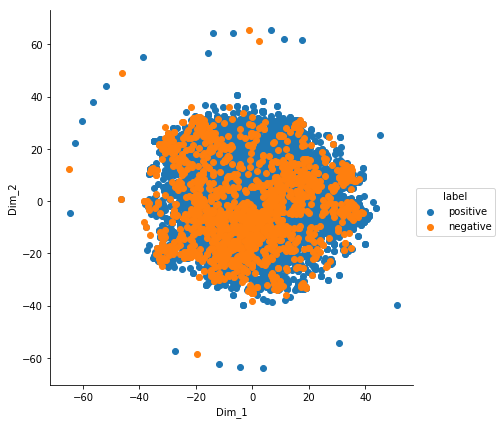

In [26]:
#BOW---> TSNE

from sklearn.manifold import TSNE
import seaborn as sn
lable= final['Score']
# Picking the top 10000 points 
vectorizer = CountVectorizer()
finalbow= vectorizer.fit_transform(ctext[:10000]).todense()
data_10000 = finalbow
labels_10000 = lable[0:10000]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_10000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_10000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

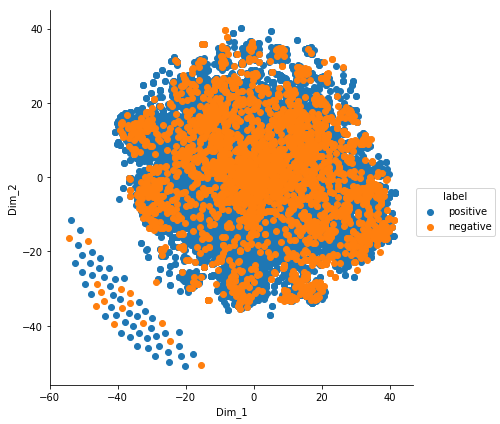

In [23]:
#BOW----> TSNE 

from sklearn.manifold import TSNE
import seaborn as sn
lable= final['Score']
vectorizer = CountVectorizer()
finalbow= vectorizer.fit_transform(ctext[:20000]).todense()
data_20000 = finalbow
labels_20000 = lable[0:20000]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_20000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_20000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [27]:
#tf-idf vec
tf_idf_data = final['CleanedText']
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(tf_idf_data[:2000].values)
print(final_tf_idf)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

  (0, 74849)	0.11742925858842608
  (0, 38836)	0.05043471873848091
  (0, 6902)	0.24505753706559721
  (0, 40757)	0.04795274952275366
  (0, 61502)	0.18665434975214495
  (0, 37058)	0.08910637722840255
  (0, 39920)	0.105787929400886
  (0, 54385)	0.25201703534001185
  (0, 9521)	0.0925458764289262
  (0, 19248)	0.09591611826166417
  (0, 1551)	0.07979679056698807
  (0, 1996)	0.061706914651773505
  (0, 60054)	0.10272585929492581
  (0, 54705)	0.13281825870326758
  (0, 31873)	0.07746504804086247
  (0, 37242)	0.0816858456885324
  (0, 74058)	0.12600851767000593
  (0, 33945)	0.13281825870326758
  (0, 19286)	0.12117692951572749
  (0, 39940)	0.03730614517047027
  (0, 45016)	0.05771758649211104
  (0, 75043)	0.09332717487607248
  (0, 34732)	0.09897818836762438
  (0, 59790)	0.11742925858842608
  (0, 11875)	0.0790969023029407
  :	:
  (1999, 18212)	0.06058023947637054
  (1999, 18653)	0.1838198859308097
  (1999, 58789)	0.09640414621336288
  (1999, 64465)	0.14047638155966685
  (1999, 61948)	0.1972495749597951

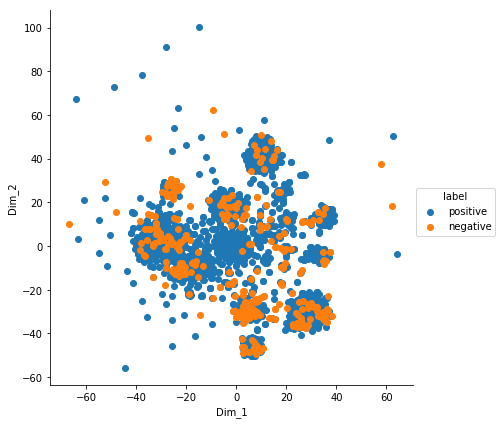

In [30]:
#tfidf
from sklearn.manifold import TSNE
import seaborn as sn
lable= final['Score']
# Picking the top 1000 points as TSNE takes a lot of time for 15K points
tf_idf_data = final['CleanedText']
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(tf_idf_data[:2000].values).todense()
data_2000 = final_tf_idf
labels_2000 = lable[0:2000]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

In [28]:
len(final['CleanedText'])
final['CleanedText'].head()

138706    witti littl book make son laugh loud recit car...
138688    grew read sendak book watch realli rosi movi i...
138689    fun way children learn month year learn poem t...
138690    great littl book read nice rhythm well good re...
138691    book poetri month year goe month cute littl po...
Name: CleanedText, dtype: object

In [29]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())
    
print(final['CleanedText'].values[0])
print("\n--------------Spliting each sentence into words--------word list of ie data corpus---------\n")
print(list_of_sent[:5])
#word list of ie data corpus

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg

--------------Spliting each sentence into words--------word list of ie data corpus---------

[['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg'], ['grew', 'read', 'sendak', 'book', 'watch', 'realli', 'rosi', 'movi', 'incorpor', 'love', 'son', 'love', 'howev', 'miss', 'hard', 'cover', 'version', 'paperback', 'seem', 'kind', 'flimsi', 'take', 'two', 'hand', 'keep', 'page', 'open'], ['fun', 'way', 'children', 'learn', 'month', 'year', 'learn', 'poem', 'throughout', 'school', 'year', 'like', 'handmot', 'invent', 'poem'], ['great', 'littl', 'book', 'r

In [30]:
#The Word to Vec model produces a vocabulary, with each word being represented by 
#an n-dimensional numpy array 
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_model.wv['man']


array([ 0.5049587 , -1.4192604 , -0.32235557,  0.06252119, -0.46066374,
        0.53408533,  0.8148425 ,  0.38676387, -1.6515129 ,  0.49450725,
        0.65562034,  0.04482038, -0.6200073 , -0.63757473, -1.0624495 ,
        0.9990745 ,  0.31199628,  2.174805  ,  0.08340626,  0.6494861 ,
       -0.08163311, -0.964118  ,  1.4553765 ,  1.8535748 ,  0.7095991 ,
       -1.2142258 ,  0.7655991 ,  0.9095243 ,  0.03082546,  0.88368535,
       -1.0153021 , -0.97908646, -1.7649624 ,  0.5796267 , -3.2797544 ,
        1.0360681 , -0.00484322,  1.373616  ,  0.8556928 , -0.16221063,
        0.9888196 , -0.20477836, -2.8966854 ,  0.4673677 ,  1.7644075 ,
       -0.62950677, -2.344305  ,  2.1681046 ,  0.26033613, -0.6805235 ],
      dtype=float32)

In [31]:
words_for_lables = list(w2v_model.wv.vocab)
print(len(words_for_lables))
type(words_for_lables)

21938


list

In [32]:
#labels = []
tokens = []

for word in w2v_model.wv.vocab:
    tokens.append(w2v_model[word])
    #labels.append(word)
    
print(len(tokens));
tokens[:2]

21938


[array([ 0.05358928, -0.06819165, -0.16991058,  0.17433462,  0.01344274,
        -0.04950779, -0.05744738, -0.11790179,  0.01557162,  0.14443101,
        -0.09710026, -0.10044734, -0.04216651, -0.04620736, -0.03105031,
         0.14677328,  0.13399816,  0.10790493, -0.18656616, -0.02583816,
         0.06750738,  0.10262351,  0.10750818,  0.04971971, -0.03428614,
        -0.14734638,  0.02206524, -0.09977639,  0.06680781,  0.10330884,
        -0.2574238 , -0.13060725,  0.07451752, -0.04236906, -0.24820751,
        -0.00706948,  0.05241673,  0.01655097, -0.0404954 ,  0.01586135,
         0.0782939 , -0.12162348,  0.00139773, -0.04456677, -0.06395328,
        -0.01016754, -0.15437643,  0.06060351,  0.15205956, -0.12461082],
       dtype=float32),
 array([ 0.2912336 , -0.32492623,  1.6722718 , -1.2586887 ,  2.2091973 ,
        -3.0240936 , -0.3098936 , -0.8691745 ,  0.42161855,  2.2259514 ,
         0.868222  ,  1.149301  , -2.2758982 , -0.4567187 ,  0.21021785,
        -1.4983385 ,  3.006

In [33]:
lable= final['Score']
lable.head()

138706    positive
138688    positive
138689    positive
138690    positive
138691    positive
Name: Score, dtype: object

In [ ]:
# word 2 Vector

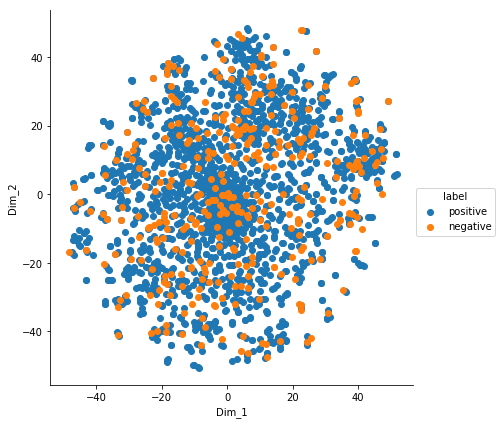

In [145]:
from sklearn.manifold import TSNE
import seaborn as sn
lable= final['Score']

data_2000 = tokens[:2000]
labels_2000 = lable[0:2000]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

In [34]:
labels = []
tokens = []

for word in w2v_model.wv.vocab:
    tokens.append(w2v_model[word])
    labels.append(word)
    
# labels
tokens

[array([ 0.05358928, -0.06819165, -0.16991058,  0.17433462,  0.01344274,
        -0.04950779, -0.05744738, -0.11790179,  0.01557162,  0.14443101,
        -0.09710026, -0.10044734, -0.04216651, -0.04620736, -0.03105031,
         0.14677328,  0.13399816,  0.10790493, -0.18656616, -0.02583816,
         0.06750738,  0.10262351,  0.10750818,  0.04971971, -0.03428614,
        -0.14734638,  0.02206524, -0.09977639,  0.06680781,  0.10330884,
        -0.2574238 , -0.13060725,  0.07451752, -0.04236906, -0.24820751,
        -0.00706948,  0.05241673,  0.01655097, -0.0404954 ,  0.01586135,
         0.0782939 , -0.12162348,  0.00139773, -0.04456677, -0.06395328,
        -0.01016754, -0.15437643,  0.06060351,  0.15205956, -0.12461082],
       dtype=float32),
 array([ 0.2912336 , -0.32492623,  1.6722718 , -1.2586887 ,  2.2091973 ,
        -3.0240936 , -0.3098936 , -0.8691745 ,  0.42161855,  2.2259514 ,
         0.868222  ,  1.149301  , -2.2758982 , -0.4567187 ,  0.21021785,
        -1.4983385 ,  3.006

In [55]:
w2v_words = list(w2v_model.wv.vocab)
# print("number of words that occured minimum 5 times ",len(w2v_words))
# print("sample words ", w2v_words[0:50])
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

364171
50


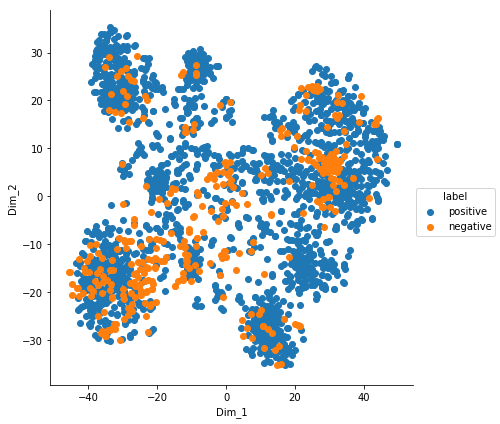

In [52]:
#avg-w2v

from sklearn.manifold import TSNE
import seaborn as sn
lable= final['Score']

data_2000 = sent_vectors[:2000]
labels_2000 = lable[0:2000]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

In [35]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

364171
50


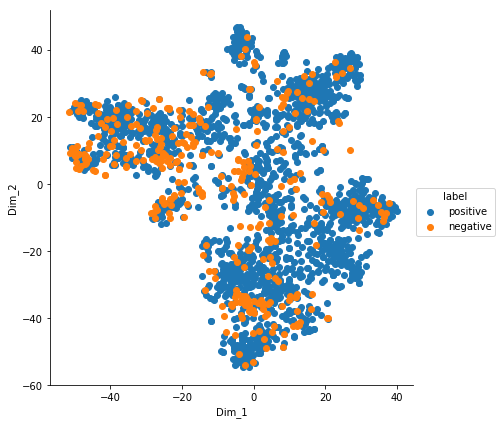

In [36]:
#TF-IDF weighted Word2Vec

from sklearn.manifold import TSNE
import seaborn as sn
lable= final['Score']

data_2000 = tfidf_sent_vectors[:2000]
labels_2000 = lable[0:2000]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()